In [2]:
import icon_registration as icon
import torch
import torchvision
import numpy as np
from icon_registration import networks
import icon_registration as icon
import icon_registration.data
import icon_registration.networks as networks
from icon_registration.config import device

import numpy as np
import torch
import torchvision.utils
import matplotlib.pyplot as plt
import torch.nn.functional as F

import multiscale_constr_model as constr

In [3]:
class RandomMatrix(icon.RegistrationModule):
    def __init__(self, scale):
        super().__init__()
        self.scale = scale
    def forward(self, a, b):
        if len(a.shape) == 4:
            noise = torch.randn(a.shape[0], 2, 2) * self.scale
            noise = noise - noise.permute([0, 2, 1])
            noise = torch.linalg.matrix_exp(noise)
            noise = torch.cat([noise, torch.zeros(a.shape[0], 2, 1)], axis=2).to(a.device)
            x = noise
            x = torch.cat(
                [
                    x,
                    torch.Tensor([[[0, 0, 1]]]).to(x.device).expand(x.shape[0], -1, -1),
                ],
                1,
            )
            x = torch.matmul(
                torch.Tensor([[1, 0, 0.5], [0, 1, 0.5], [0, 0, 1]]).to(x.device), x
            )
            x = torch.matmul(
                x,
                torch.Tensor([[1, 0, -0.5], [0, 1, -0.5], [0, 0, 1]]).to(x.device),
            )
            return x
        elif len(a.shape) == 5:
            noise = torch.randn(a.shape[0], 3, 3) * 13
            noise = noise - noise.permute([0, 2, 1])
            noise = torch.linalg.matrix_exp(noise)
            noise = torch.cat([noise, torch.zeros(a.shape[0], 3, 1)], axis=2).to(a.device)
            x = noise
            x = torch.cat(
                [
                    x,
                    torch.Tensor([[[0, 0, 0, 1]]]).to(x.device).expand(x.shape[0], -1, -1),
                ],
                1,
            )
            x = torch.matmul(
                torch.Tensor([[1, 0, 0, 0.5], [0, 1, 0, 0.5], [0, 0, 1, 0.5], [0, 0, 0, 1]]).to(x.device), x
            )
            x = torch.matmul(
                x,
                torch.Tensor([[1, 0, 0, -0.5], [0, 1, 0, -0.5], [0, 0, 1, -0.5], [0, 0, 0, 1]]).to(x.device),
            )
            return x


class RotationFunctionFromVectorField(icon.RegistrationModule):
    def __init__(self, net):
        super().__init__()
        self.net = net
    def forward(self, a, b):
        displacements = self.net(a, b)
        field = self.as_function(displacements)

        def transform(coords):
            coords_reflected = coords - 2 * coords * (coords < 0) - 2 * (coords - 1) * (coords > 1)
            if hasattr(coords, "isIdentity") and coords.shape == displacements.shape:
                return coords + displacemnts
            return coords + 2 * field(coords) - field(coords_reflected)
        return transform

class FunctionsFromMatrix(icon.RegistrationModule):
    """
    wrap an inner neural network `net` that returns an N x N+1 matrix representing
    an affine transform, into a RegistrationModule that returns a function that
    transforms a tensor of coordinates.
    """

    def __init__(self, net):
        super().__init__()
        self.net = net

    def forward(self, image_A, image_B):
        matrix_phi = self.net(image_A, image_B).detach().clone()
        matrix_phi = np.array(matrix_phi.cpu().detach())
        matrix_phi = torch.tensor(matrix_phi).to(image_A.device)

        def transform(tensor_of_coordinates):
            shape = list(tensor_of_coordinates.shape)
            shape[1] = 1
            coordinates_homogeneous = torch.cat(
                [tensor_of_coordinates, torch.ones(shape, device=tensor_of_coordinates.device)], axis=1
            )
            return icon.network_wrappers.multiply_matrix_vectorfield(matrix_phi, coordinates_homogeneous)[:, :-1]

        inv = torch.linalg.inv(matrix_phi.detach().clone())

        def invtransform(tensor_of_coordinates):
            shape = list(tensor_of_coordinates.shape)
            shape[1] = 1
            coordinates_homogeneous = torch.cat(
                [tensor_of_coordinates, torch.ones(shape, device=tensor_of_coordinates.device)], axis=1
            )
            return icon.network_wrappers.multiply_matrix_vectorfield(inv, 
                    coordinates_homogeneous)[:, :-1]

        return transform, invtransform

class DoubleStep(icon.RegistrationModule):

    def __init__(self, netPhi, netPsi):
        super().__init__()
        self.netPhi = netPhi
        self.netPsi = netPsi

    def forward(self, image_A, image_B):
        
        # Tag for shortcutting hack. Must be set at the beginning of 
        # forward because it is not preserved by .to(config.device)
        self.identity_map.isIdentity = True
            
        phi, invphi = self.netPhi(image_A, image_B)
        psi = self.netPsi(
            self.as_function(image_A)(invphi(self.identity_map)),
            self.as_function(image_B)(invphi(self.identity_map)),
        )
        return lambda tensor_of_coordinates: invphi(psi(phi(tensor_of_coordinates)))



/playpen-raid1/tgreer/flash_attention/venv/lib/python3.8/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/playpen-raid1/tgreer/flash_attention/venv/lib/python3.8/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


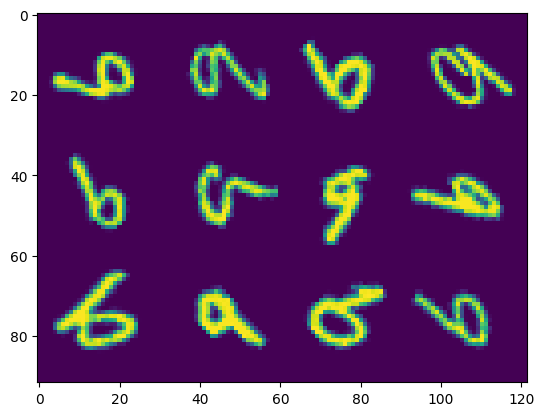

In [92]:
def augment(image_A):

    noise = torch.randn((image_A.shape[0], 2, 2))

    noise = noise - torch.permute(noise, (0, 2, 1))

    forward = torch.linalg.matrix_exp(noise / .0200)

    full = torch.zeros((image_A.shape[0], 2, 3))

    full[:, :2, :2] = forward

    grid_shape = list(image_A.shape)
    grid_shape[1] = 2
    forward_grid = F.affine_grid(full, grid_shape)

    warped_A = F.grid_sample(image_A, forward_grid, padding_mode="border")

    return warped_A
def show(tensor):
        plt.imshow(torchvision.utils.make_grid(tensor[:16], nrow=4)[0].cpu().detach())
        plt.xticks([])
        plt.yticks([])

def get_dataset_mnist(split, number=9):
    ds = torch.utils.data.DataLoader(
        torchvision.datasets.MNIST(
            "./files/",
            transform=torchvision.transforms.ToTensor(),
            download=True,
            train=(split == "train"),
        ),
        batch_size=500,
    )
    images = []
    for _, batch in enumerate(ds):
        label = np.array(batch[1])
        batch_nines = label == number
        batch = augment(torch.tensor(np.array(batch[0])[batch_nines]))
        
        images.append(batch)
    images = torch.cat(images)

    ds = torch.utils.data.TensorDataset(torch.Tensor(images))
    d1, d2 = (
        torch.utils.data.DataLoader(
            ds,
            batch_size=128,
            shuffle=True,
        )
        for _ in (1, 1)
    )
    return d1, d2


def show(tensor):
    plt.imshow(torchvision.utils.make_grid(tensor[:16], nrow=4)[0].cpu().detach())
    plt.xticks([])
    plt.yticks([])
    
def performance(net, eopchs):
    if eopchs:
      net.assign_identity_map(sample_batch.shape)
      net.train()
      net.to(device)

      optim = torch.optim.Adam(net.parameters(), lr=0.001)
      curves = icon.train_datasets(net, optim, ds, ds, epochs=eopchs)
    
      plt.plot(np.array(curves)[:, :3])
      plt.show()
    
    
    image_A = next(iter(ds))[0].to(device)
    image_B = next(iter(ds))[0].to(device)
    with torch.no_grad():
        net(image_A, image_B)
    plt.subplot(2, 2, 1)
    show(image_A)
    plt.subplot(2, 2, 2)
    show(image_B)
    plt.subplot(2, 2, 3)
    show(net.warped_image_A)
    plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:16], nrow=4)[0].cpu().detach())
    plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:16], nrow=4)[1].cpu().detach())
    plt.subplot(2, 2, 4)
    show(net.warped_image_A - image_B)
    plt.tight_layout()
    plt.show()
    return curves[-1][2]


d1, d2 = get_dataset_mnist("train", number=9)
#d1, d2 = icon.data.get_dataset_triangles(hollow=True, data_size=64)
ds = d1

import matplotlib.pyplot as plt
sample_batch = next(iter(ds))[0]
plt.imshow(torchvision.utils.make_grid(sample_batch[:12], nrow=4)[0])

In [37]:
def show(tensor):
    plt.imshow(torchvision.utils.make_grid(tensor[:16], nrow=4)[0].cpu().detach())
    plt.xticks([])
    plt.yticks([])

In [38]:
#net.identity_map

def even_pad(img, amt):
    return F.pad(img, (amt,) * 4, "replicate") * 2 - F.pad(img, (amt,) * 4, "reflect")
from icon_registration.losses import _get_gaussian_kernel1d

def even_blur(tensor, sigma):

    kernel_size = 3 * sigma
    kernel_size += 1 - kernel_size%2
    
    kernel1d = _get_gaussian_kernel1d(kernel_size=kernel_size, sigma=sigma).to(
        tensor.device, dtype=tensor.dtype
    )
    out = tensor
    group = tensor.shape[1]

    out = even_pad(out, kernel_size // 2)

    if len(tensor.shape) - 2 == 1:
        out = torch.conv1d(out, kernel1d[None, None, :].expand(group,-1,-1), groups=group)
    elif len(tensor.shape) - 2 == 2:
        out = torch.conv2d(out, kernel1d[None, None, :, None].expand(group,-1,-1,-1), groups=group)
        out = torch.conv2d(out, kernel1d[None, None, None, :].expand(group,-1,-1,-1), groups=group)
    elif len(tensor.shape) - 2 == 3:
        out = torch.conv3d(out, kernel1d[None, None, :, None, None].expand(group,-1,-1,-1,-1), groups=group)
        out = torch.conv3d(out, kernel1d[None, None, None, :, None].expand(group,-1,-1,-1,-1), groups=group)
        out = torch.conv3d(out, kernel1d[None, None, None, None, :].expand(group,-1,-1,-1,-1), groups=group)


    return out


    
    
#plt.imshow(even_blur(net.identity_map, 3)[0, 0].cpu())

In [39]:
(4,) * 3

(4, 4, 4)

In [87]:

class Blur(icon.network_wrappers.RegistrationModule):
    def __init__(self, net, radius):
        super().__init__()
        self.radius = radius
        self.net = net
    def forward(self, A, B):
        phi = self.net(A, B)(self.identity_map)
        phi = even_blur(phi, self.radius)
        field = self.as_function(phi - self.identity_map)

        def transform(coords):
            coords_reflected = coords - 2 * coords * (coords < 0) - 2 * (coords - 1) * (coords > 1)
            if hasattr(coords, "isIdentity") and coords.shape == phi.shape:
                return coords + displacemnts
            return coords + 2 * field(coords) - field(coords_reflected)
        return transform

class Expected(icon.network_wrappers.RegistrationModule):
    def __init__(self, net, calls):
        super().__init__()
        self.calls = calls
        self.net = net
    def forward(self, A, B):

        phi = self.net(A, B)(self.identity_map)
        for i in range(self.calls - 1):
            phi = phi + self.net(A, B)(self.identity_map)
        phi = phi / self.calls
        field = self.as_function(phi - self.identity_map)

        def transform(coords):
            coords_reflected = coords - 2 * coords * (coords < 0) - 2 * (coords - 1) * (coords > 1)
            if hasattr(coords, "isIdentity") and coords.shape == phi.shape:
                return coords + displacemnts
            return coords + 2 * field(coords) - field(coords_reflected)
        return transform

In [41]:
from torch import nn
import torch
from torch import nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.norm1 = nn.LayerNorm(channels)
        self.dense1 = nn.Linear(channels, channels)
        self.norm2 = nn.LayerNorm(channels)
        self.dense2 = nn.Linear(channels, channels)
        
    def forward(self, x):
        identity = x
        x = self.norm1(x)
        x = F.relu(self.dense1(x))
        x = self.norm2(x)
        x = self.dense2(x)
        # No ReLU after the residual connection to allow negative values
        return x + identity

class FCNet(nn.Module):
    def __init__(self, size=28):
        super().__init__()
        self.size = size
        self.dense1 = nn.Linear(size * size * 2, 4 * 512)
        
        # Residual blocks
        self.res1 = ResidualBlock(4 * 512)
        self.res2 = ResidualBlock(4 * 512)
        self.res3 = ResidualBlock(4 * 512)
        
        self.dense3 = nn.Linear(4 * 512, size * size * 2)
        # Initialize last layer to zeros to make it easier to output zeros initially
        torch.nn.init.zeros_(self.dense3.weight)
        torch.nn.init.zeros_(self.dense3.bias)
        
    def forward(self, x, y):
        x = torch.reshape(torch.cat([x, y], 1), (-1, 2 * self.size * self.size))
        # Removed input normalization to allow uniform inputs through
        x = F.relu(self.dense1(x))
        
        # Apply residual blocks
        x = self.res1(x)
        x = self.res2(x)
        x = self.res3(x)
        
        # Removed final normalization to allow uniform outputs
        x = self.dense3(x)
        x = torch.reshape(x, (-1, 2, self.size, self.size))
        return x

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [08:45<00:00, 58.36s/it]


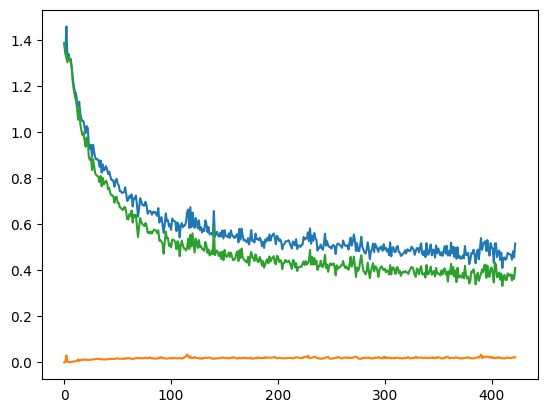

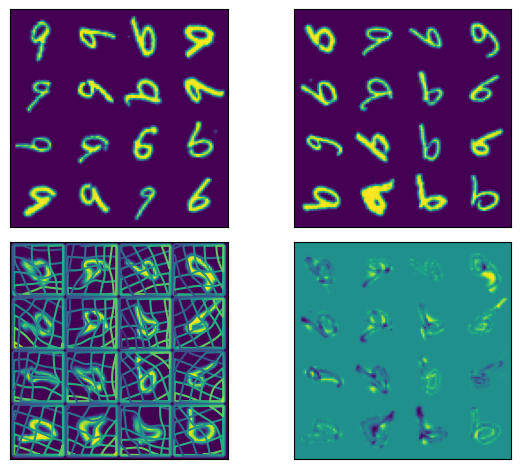

0.41081327199935913

In [94]:
#regnet = FCNet()

#torch.nn.init.zeros_(regnet.dense3.weight)
regnet = networks.tallUNet2(dimension=2)
inner_net = RotationFunctionFromVectorField(regnet)

for i in range(6):
     #regnet = networks.tallUNet2(dimension=2)

     inner_net = icon.TwoStepRegistration(
         Blur(inner_net, [15, 12, 9, 6, 6, 6, 6, 6][i]),
         Expected(DoubleStep(FunctionsFromMatrix(RandomMatrix(10)), RotationFunctionFromVectorField(regnet)), calls=5)
     )

net = icon.losses.GradientICON(inner_net, icon.LNCC(sigma=4), lmbda=4.5)

#print(net)

performance(net, 9)

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [01:26<00:00,  9.63s/it]


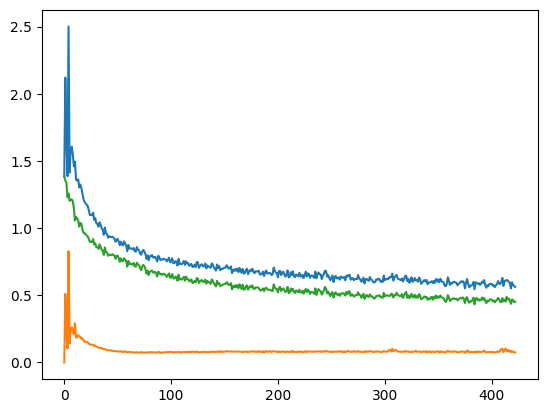

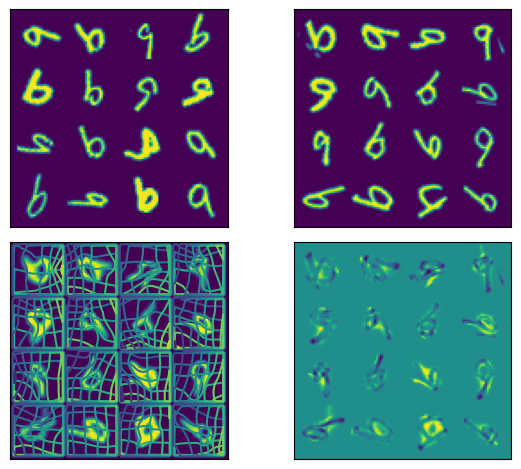

0.451930433511734

In [32]:
regnet = FCNet()
#torch.nn.init.zeros_(regnet.dense3.weight)
#regnet = networks.tallUNet2(dimension=2)
inner_net = RotationFunctionFromVectorField(regnet)

for i in range(6):
     #regnet = networks.tallUNet2(dimension=2)

     inner_net = icon.TwoStepRegistration(
         Blur(inner_net, [15, 12, 9, 6, 6, 6][i]),
         DoubleStep(FunctionsFromMatrix(RandomMatrix(10)), RotationFunctionFromVectorField(regnet))
     )

net = icon.losses.GradientICON(inner_net, icon.LNCC(sigma=4), lmbda=1.5)

#print(net)

performance(net, 9)

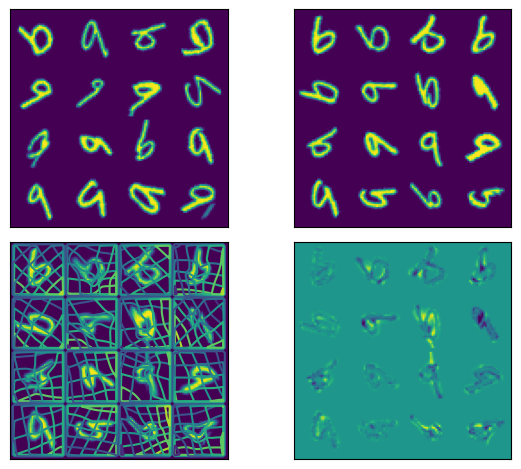

In [65]:
inner_net = RotationFunctionFromVectorField(regnet)

for i in range(12):
     #regnet = networks.tallUNet2(dimension=2)
     inner_net = icon.TwoStepRegistration(
         inner_net,
         icon.FunctionFromMatrix(RandomMatrix(0* (1/12) * (12 - i))),
     )

     inner_net = icon.TwoStepRegistration(
         Blur(inner_net, 15),
         DoubleStep(FunctionsFromMatrix(RandomMatrix(13)), RotationFunctionFromVectorField(regnet))
     )




for i in range(6):
     #regnet = networks.tallUNet2(dimension=2)

     inner_net = icon.TwoStepRegistration(
         Blur(inner_net, [15, 12, 9, 6, 6, 6][i]),
         DoubleStep(FunctionsFromMatrix(RandomMatrix(13)), RotationFunctionFromVectorField(regnet))
     )

net = icon.losses.GradientICON(inner_net, icon.LNCC(sigma=4), lmbda=1.5)

#print(net)

net = icon.losses.GradientICON(inner_net, icon.LNCC(sigma=4), lmbda=2)
net.assign_identity_map(sample_batch.shape)
net.cuda()
try:
    
   with torch.no_grad():
      performance(net, 0)
except:
    pass

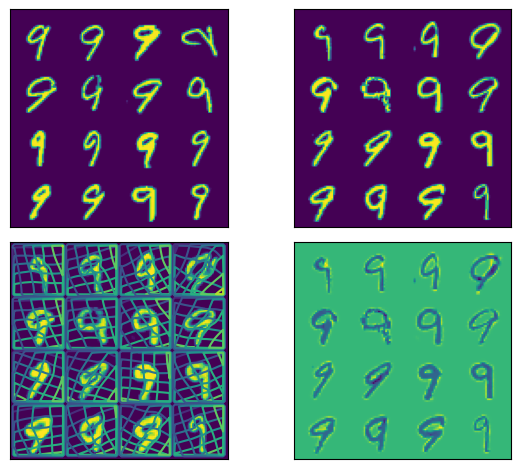

In [237]:

image_A = next(iter(ds))[0].to(device) 
image_B = next(iter(ds))[0].to(device)* 2
with torch.no_grad():
    net(image_A, image_B)
plt.subplot(2, 2, 1)
show(image_A)
plt.subplot(2, 2, 2)
show(image_B)
plt.subplot(2, 2, 3)
show(net.warped_image_A)
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:16], nrow=4)[0].cpu().detach())
plt.contour(torchvision.utils.make_grid(net.phi_AB_vectorfield[:16], nrow=4)[1].cpu().detach())
plt.subplot(2, 2, 4)
show(net.warped_image_A - image_B)
plt.tight_layout()
plt.show()

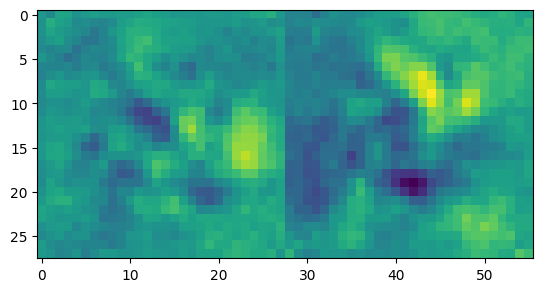

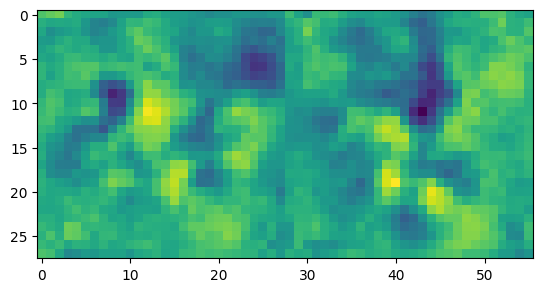

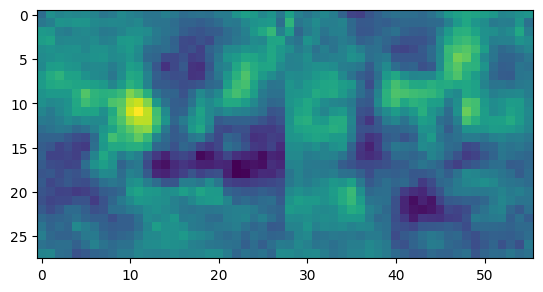

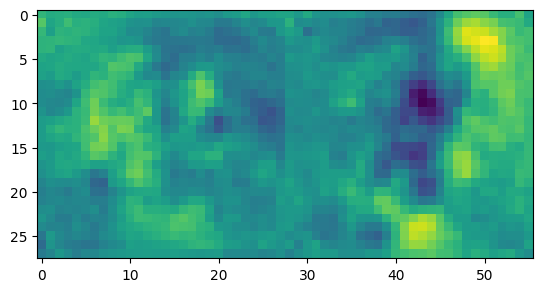

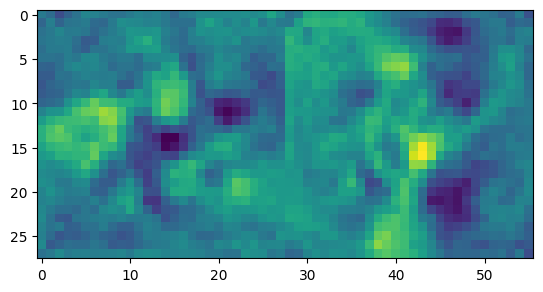

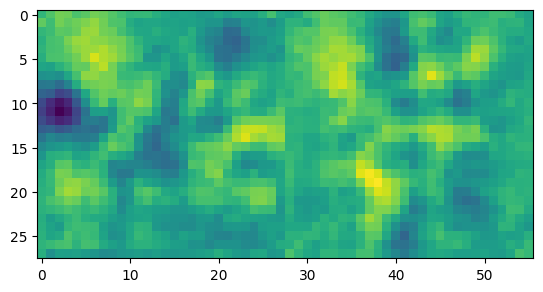

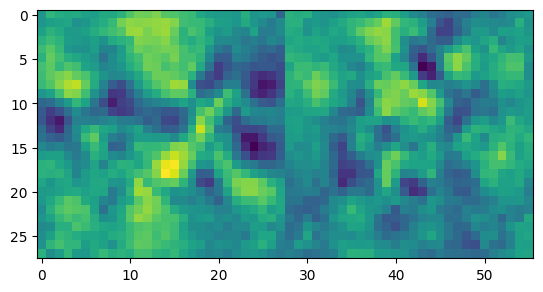

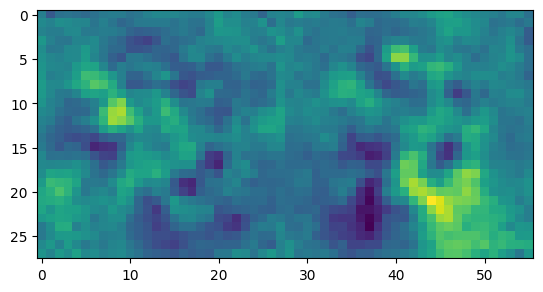

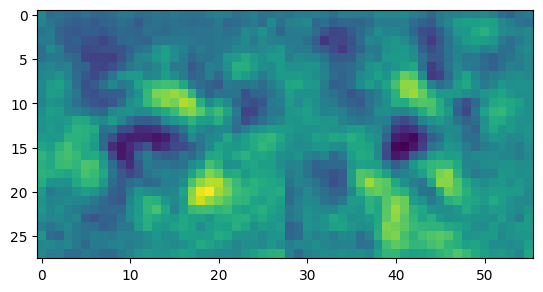

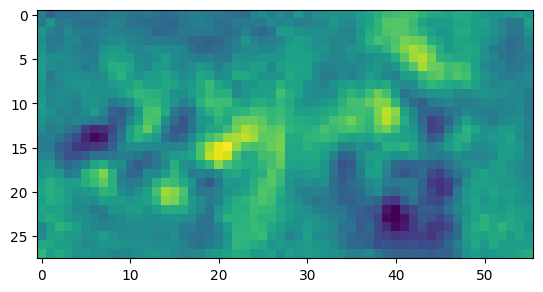

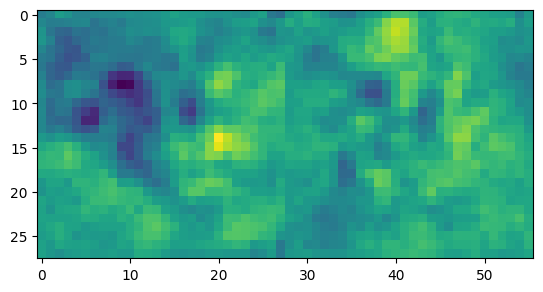

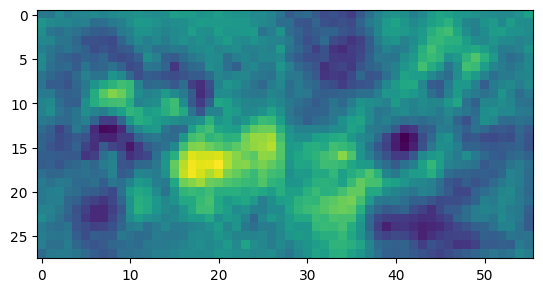

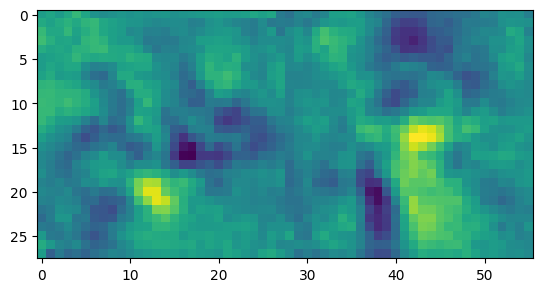

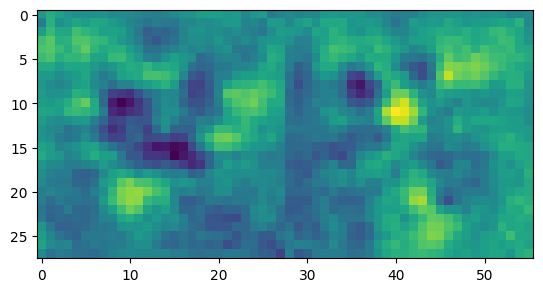

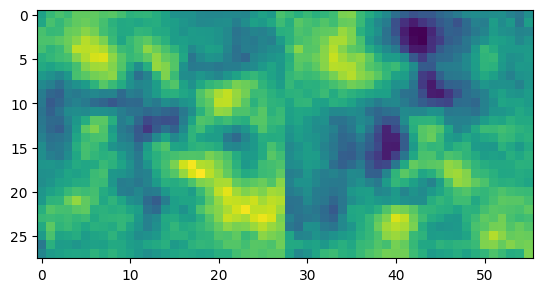

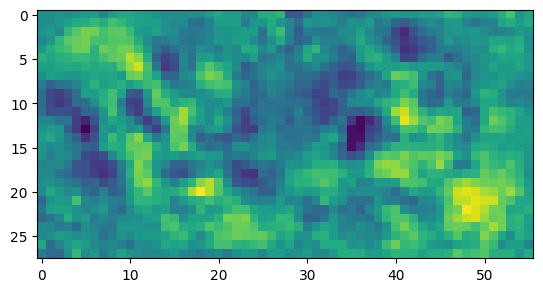

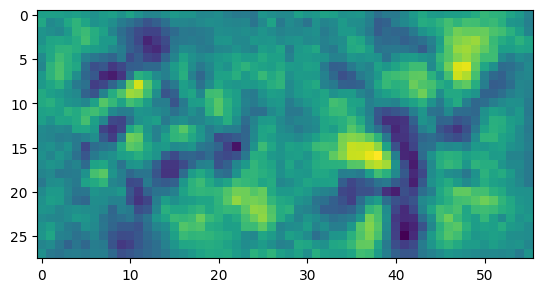

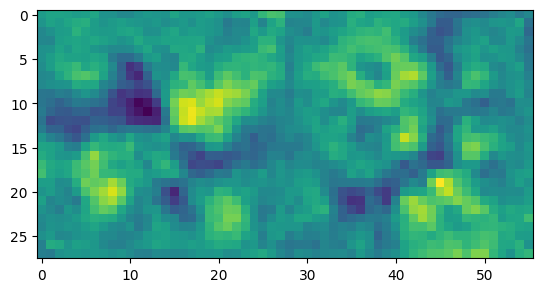

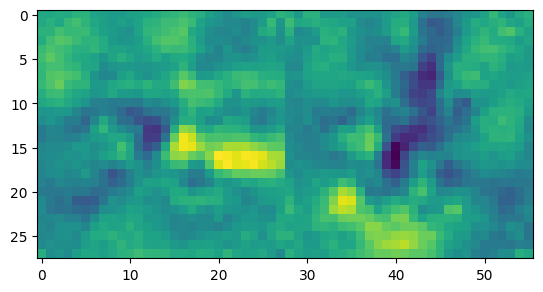

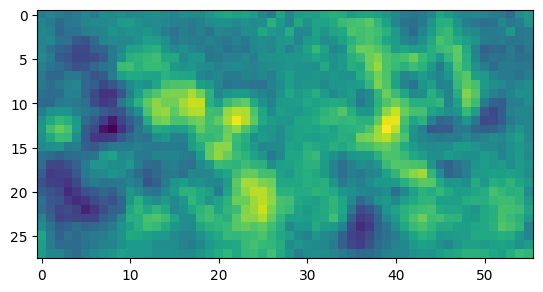

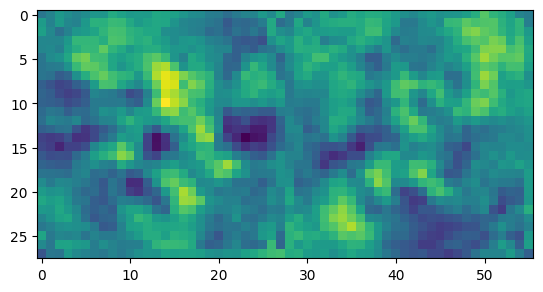

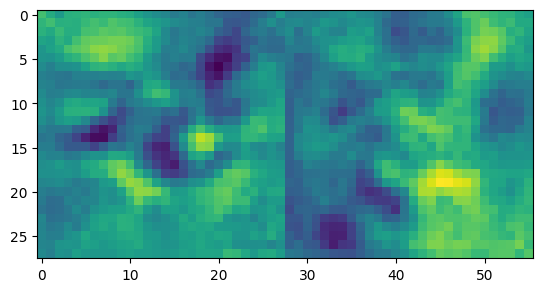

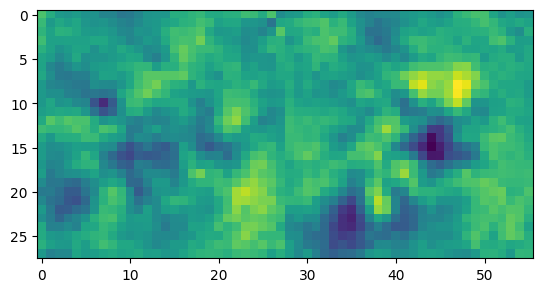

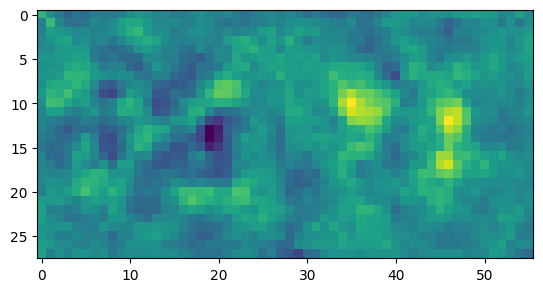

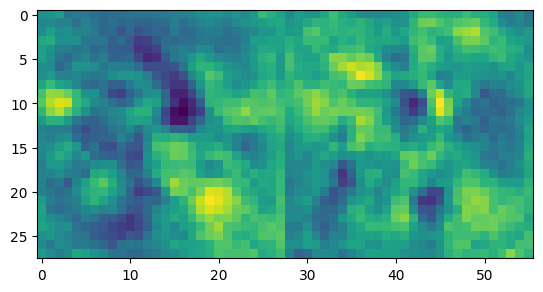

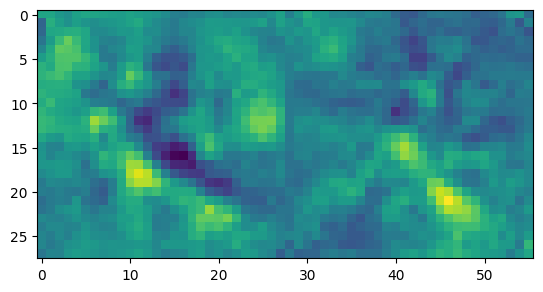

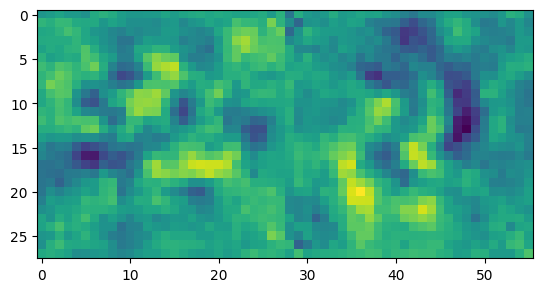

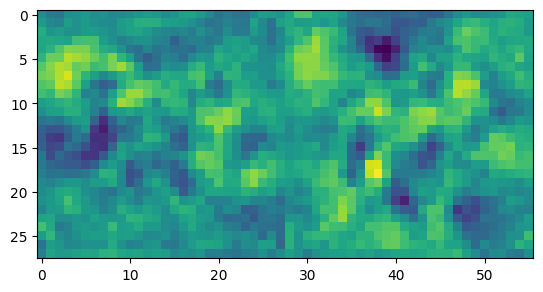

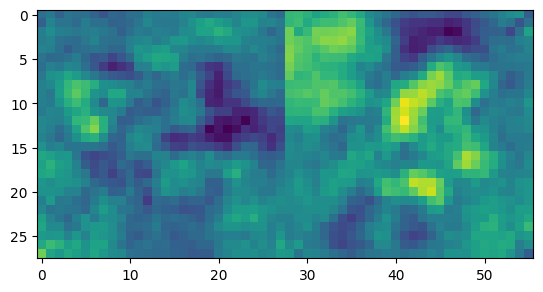

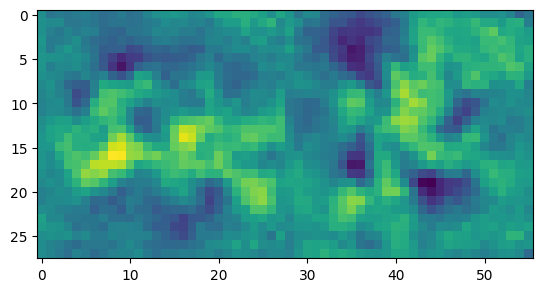

In [57]:
for i in range(30):
    plt.imshow(regnet.dense3.weight[:, i].detach().cpu().reshape(28 * 2, 28).transpose(0, 1))
    plt.show()


In [58]:
v = regnet.dense3.weight.detach().cpu().numpy()

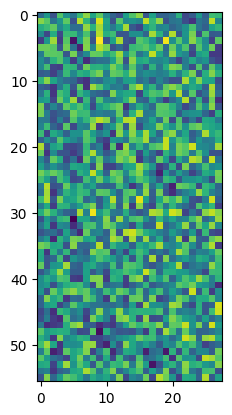

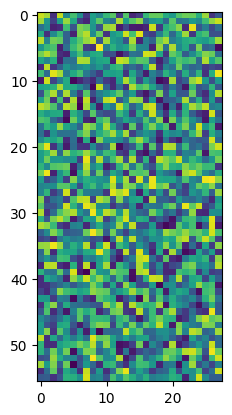

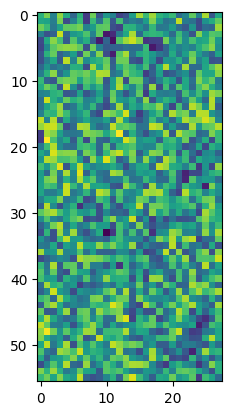

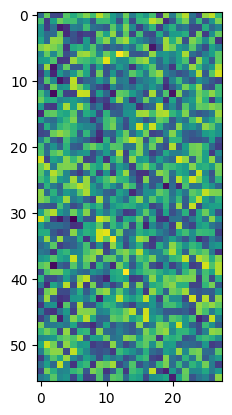

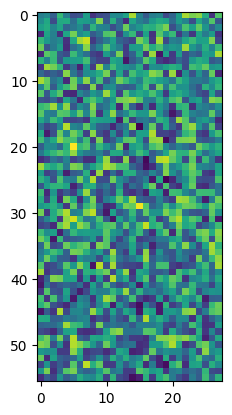

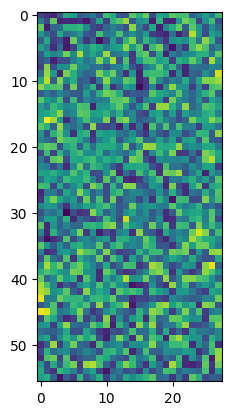

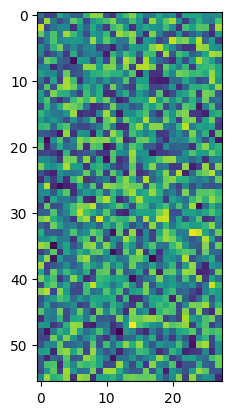

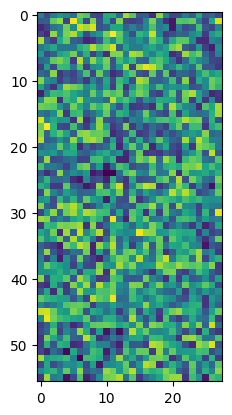

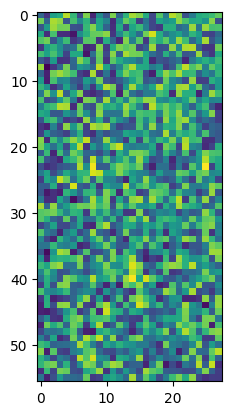

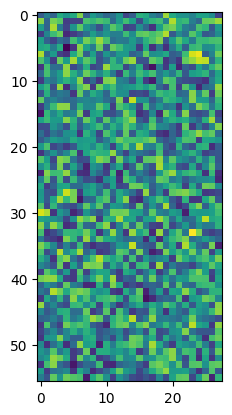

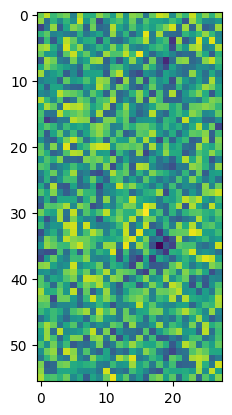

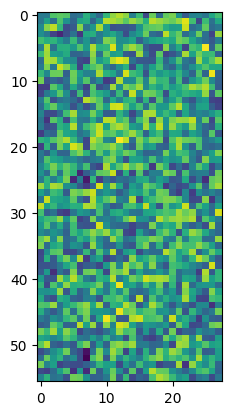

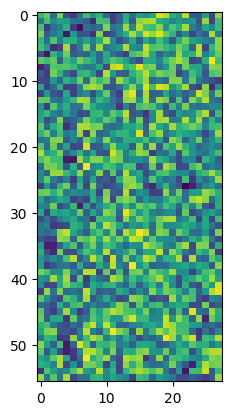

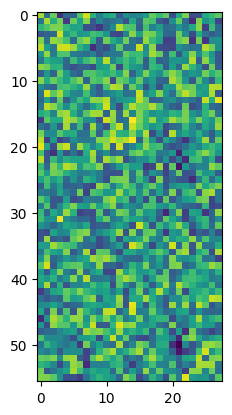

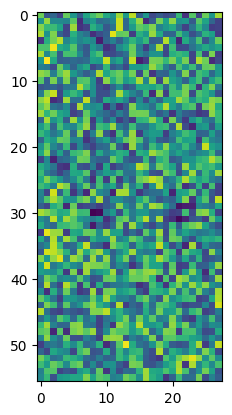

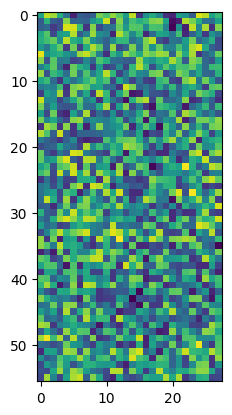

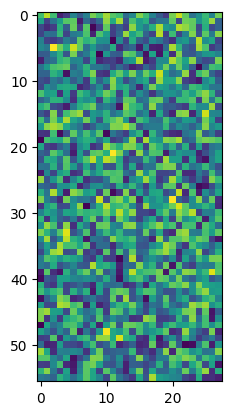

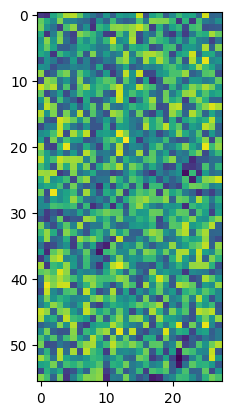

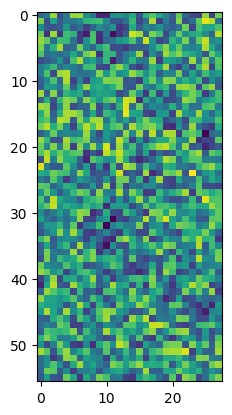

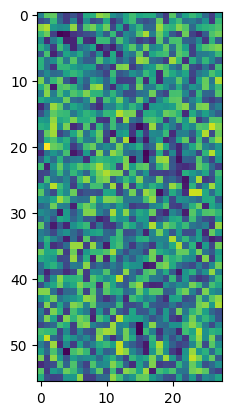

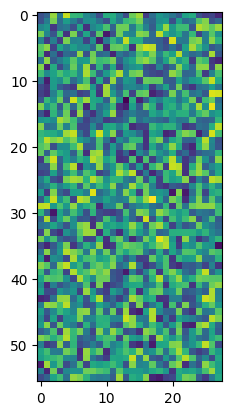

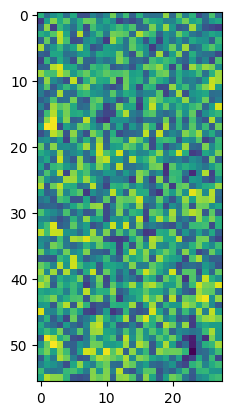

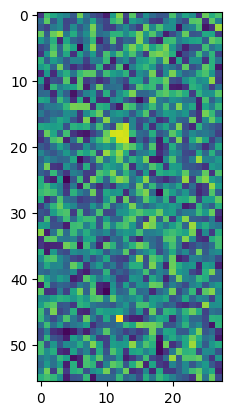

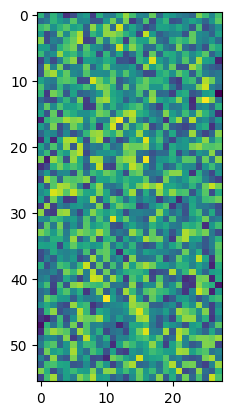

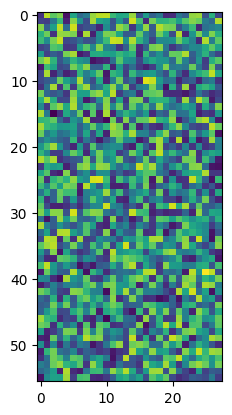

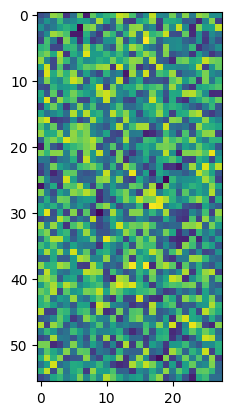

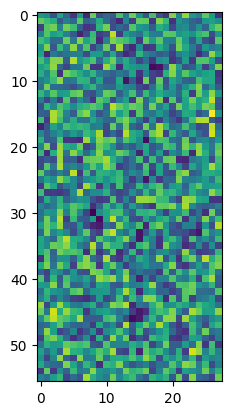

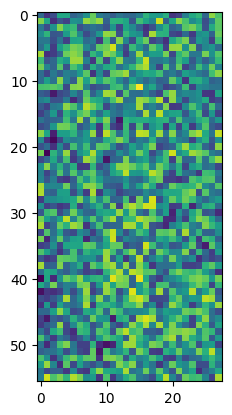

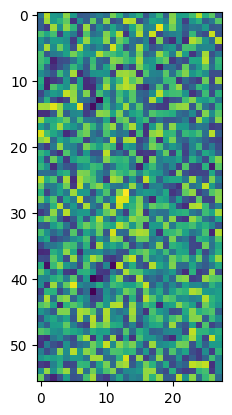

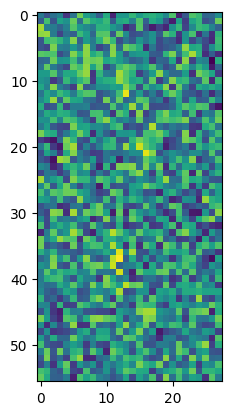

In [62]:
for i in range(30):
    plt.imshow(regnet.dense1.weight[i, :].detach().cpu().reshape(28, 28 * 2).transpose(0, 1))
    plt.show()

In [61]:
regnet

FCNet(
  (dense1): Linear(in_features=1568, out_features=2048, bias=True)
  (res1): ResidualBlock(
    (norm1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (dense1): Linear(in_features=2048, out_features=2048, bias=True)
    (norm2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (dense2): Linear(in_features=2048, out_features=2048, bias=True)
  )
  (res2): ResidualBlock(
    (norm1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (dense1): Linear(in_features=2048, out_features=2048, bias=True)
    (norm2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (dense2): Linear(in_features=2048, out_features=2048, bias=True)
  )
  (res3): ResidualBlock(
    (norm1): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (dense1): Linear(in_features=2048, out_features=2048, bias=True)
    (norm2): LayerNorm((2048,), eps=1e-05, elementwise_affine=True)
    (dense2): Linear(in_features=2048, out_features=2048, bias=True)
  )
  (dense3): Linea

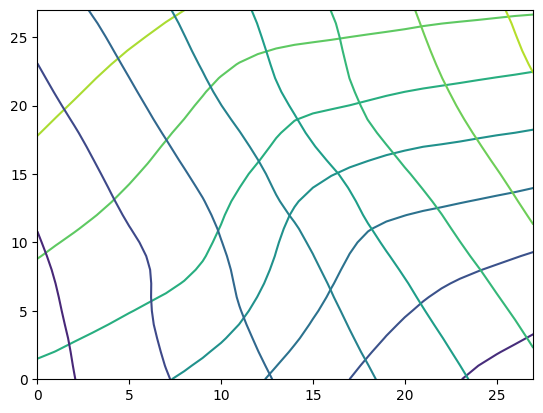

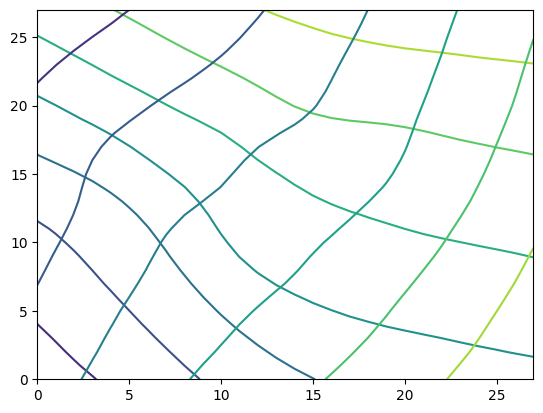

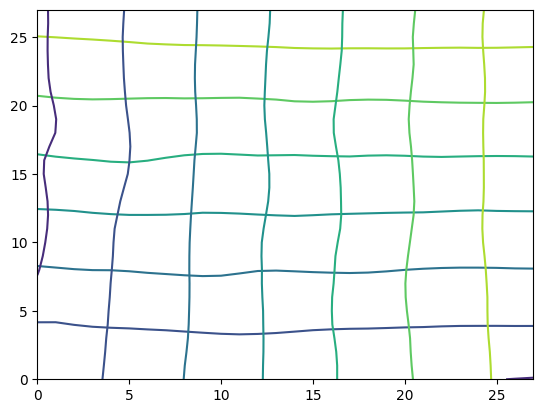

In [95]:
j = 39
plt.contour(net.phi_AB_vectorfield[j, 0].cpu())
plt.contour(net.phi_AB_vectorfield[j, 1].cpu())

plt.show()
plt.contour(net.phi_BA_vectorfield[j, 0].cpu())
plt.contour(net.phi_BA_vectorfield[j, 1].cpu())
plt.show()

comp = net.phi_AB(net.phi_BA(net.identity_map)).cpu()

plt.contour(comp[j, 0])
plt.contour(comp[j, 1])

In [82]:
net.identity_map.flip?

Docstring:
flip(dims) -> Tensor

See :func:`torch.flip`
Type:      builtin_function_or_method